In [1]:
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import pandas as pd
import math
import matplotlib.pyplot as plt
import pylab
from random import random
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16.0, 9.0)
import warnings

In [2]:
class Country():
    def __init__(self, iso, name, geometry):
        self.iso = iso
        self.name = name
        self.geometry = geometry
        self.properties = {}
    def __str__(self):
        return self.iso
    def __repr__(self):
        return '<Country Object "' + self.iso + '">'

In [3]:
shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries_on_map = reader.records()

countries = []
for country_on_map in countries_on_map:
    iso = country_on_map.attributes['iso_a3']
    name = country_on_map.attributes['name']
    geometry = country_on_map.geometry
    countries.append(Country(iso, name, geometry))

In [4]:
def plot_map(country_list, property_to_plot, colormap='rainbow', min_value=0, max_value=1):
    def color_country(ax, color, country):
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                            facecolor=color)
    cmap=plt.get_cmap(colormap)

    # hack colorbar
    CS3 = plt.imshow([[min_value, 0], [0, max_value]], cmap=cmap)
    plt.clf()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax = plt.axes(projection=cartopy.crs.Robinson())
    ax.add_feature(cartopy.feature.OCEAN)

    missing_countries = []
    for country in countries:
        color = (1,1,1)
        try:
            if not math.isnan(country.properties[property_to_plot]):
                color = cmap((country.properties[property_to_plot] - min_value)/(max_value - min_value))
        except KeyError as k:
            missing_countries.append(country.iso)
        color_country(ax, color, country)
    if missing_countries:
        print("No property", property_to_plot, "for countries", missing_countries, ".")
    plt.colorbar(CS3, orientation='horizontal', aspect=50)
    plt.show()

In [5]:
population_data = pd.read_csv('/home/julian/Code/hpk-symposium/resources/sp.pop.totl_Indicator_en_csv_v2.csv', header=2)
iso = population_data['Country Code']
population = population_data['2010']
population.index = iso

In [6]:
def add_country_property(countries, property_name, property_table):
    for country in countries:
        try:
            country.properties[property_name] = property_table[country.iso]
        except KeyError as k:
            country.properties[property_name] = float('NaN')

In [7]:
add_country_property(countries, 'population', population)

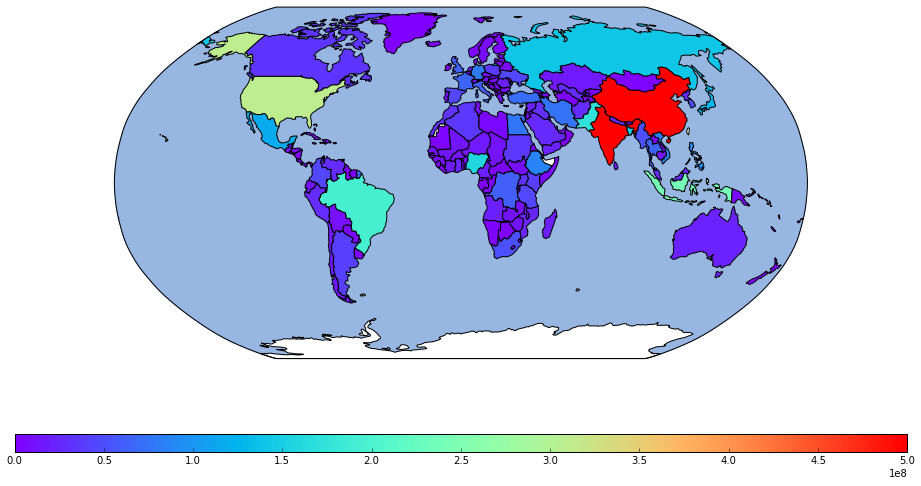

In [8]:
plot_map(countries, 'population', max_value=.5e+9)

In [9]:
temperature_data = pd.read_excel('/home/julian/Code/hpk-symposium/resources/cckp_historical_data_0.xls', 
                                 sheetname='Country_temperatureCRU')
iso = temperature_data['ISO_3DIGIT']
annual_mean_temperature = temperature_data['Annual_temp']
annual_mean_temperature.index = iso.values

In [10]:
add_country_property(countries, 'temperature', annual_mean_temperature)

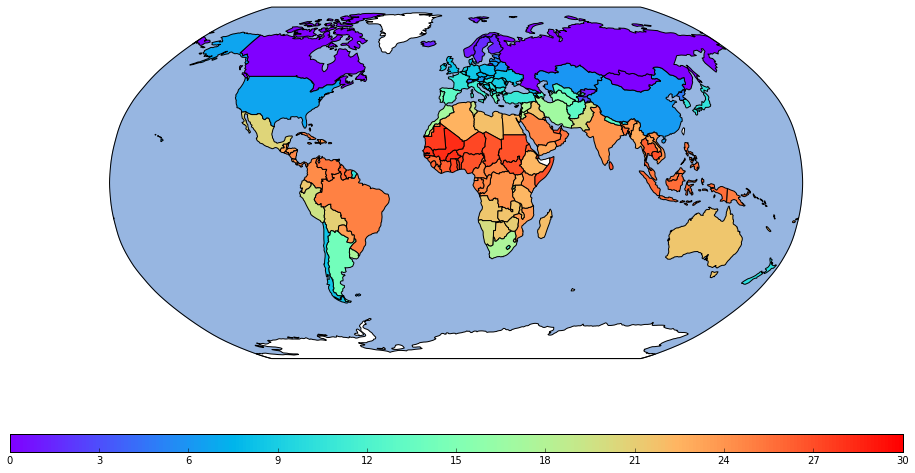

In [11]:
plot_map(countries, 'temperature', 'rainbow', min_value=0, max_value=30)

In [12]:
refugees_outgoing_data = pd.read_csv('/home/julian/Code/hpk-symposium/resources/sm.pop.refg.or_Indicator_en_csv_v2.csv', 
                                   header=1)
iso = refugees_outgoing_data['Country Code']
refugees_outgoing = refugees_outgoing_data['2012']
refugees_outgoing.index = iso
add_country_property(countries, 'refugees outgoing', refugees_outgoing)

refugees_incoming_data = pd.read_csv('/home/julian/Code/hpk-symposium/resources/sm.pop.refg_Indicator_en_csv_v2.csv', 
                                        header=1)
iso = refugees_incoming_data['Country Code']
refugees_incoming = refugees_incoming_data['2012']
refugees_incoming.index = iso
add_country_property(countries, 'refugees incoming', refugees_incoming)

In [13]:
for country in countries:
    country.properties['net refugees'] = country.properties['refugees outgoing'] - country.properties['refugees incoming']

In [ ]:
plot_map(countries, 'net refugees', colormap='seismic', min_value=-1e+6, max_value=1e+6)

In [31]:
for country in countries:
    country.properties['temperature'] = country.properties['temperature'] + 2

In [32]:
MOST_COMFORTABLE_TEMPERATURE = 18.0
FRACTION_LEAVING_PER_UNCOMFORTABLE_DEGREE = .0005
REFUGEE_INCREASE_PER_UNCOMFORTABLE_DEGREE = .2

In [33]:
for country in countries:
    temperature = country.properties['temperature']
    net_refugees = country.properties['net refugees']
    population = country.properties['population']
    uncomfortable_heat = max(0, temperature - MOST_COMFORTABLE_TEMPERATURE)
    regular_population_leaving = uncomfortable_heat * FRACTION_LEAVING_PER_UNCOMFORTABLE_DEGREE * population
    increased_refugee_stream = max(0, uncomfortable_heat * REFUGEE_INCREASE_PER_UNCOMFORTABLE_DEGREE * net_refugees)
    country.properties['net climate refugees'] = regular_population_leaving + increased_refugee_stream

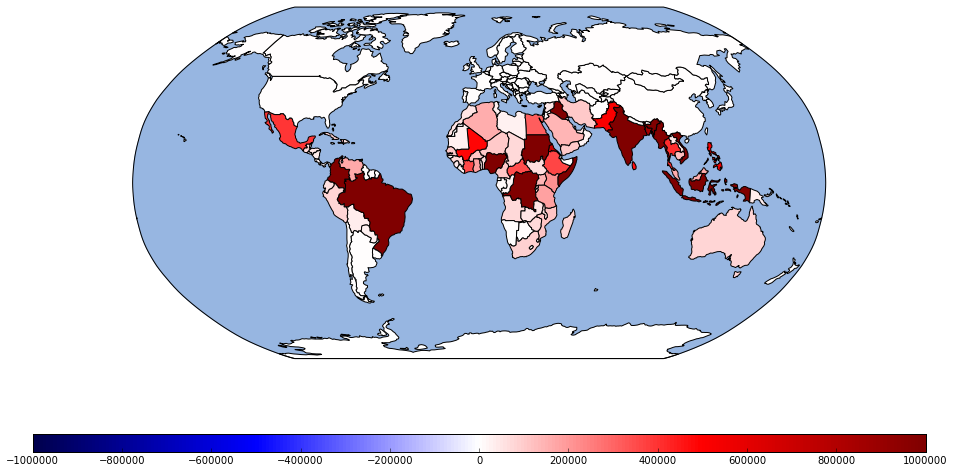

In [34]:
plot_map(countries, 'net climate refugees', max_value=1e6, min_value = -1e6, colormap='seismic')

In [35]:
def add_up(countries, property_to_add_up):
    total = 0
    for country in countries:
        if math.isfinite(country.properties[property_to_add_up]):
            total += country.properties[property_to_add_up]
    if total > 1e5:
        print("Total %s: %.2f millions." % (property_to_add_up, total/1e6))
    else:
        print("Total %s: %.f." % (property_to_add_up, total))
    return total

In [36]:
total_climate_refugees = add_up(countries, 'net climate refugees')

Total net climate refugees: 29.60 millions.


In [37]:
economic_data = pd.read_csv('/home/julian/Code/hpk-symposium/resources/d67eb1a5-9d13-4a2e-ae73-c61544832c1c_Data.csv', 
                            header=0, na_values='..')
gdp_section = economic_data[economic_data[:]['Series Code'] == 'NY.GDP.PCAP.CD']
gdp = pd.Series(index=gdp_section['Country Code'].values, data=gdp_section['2012 [YR2012]'].values)

In [38]:
add_country_property(countries, 'gdp per capita', gdp)

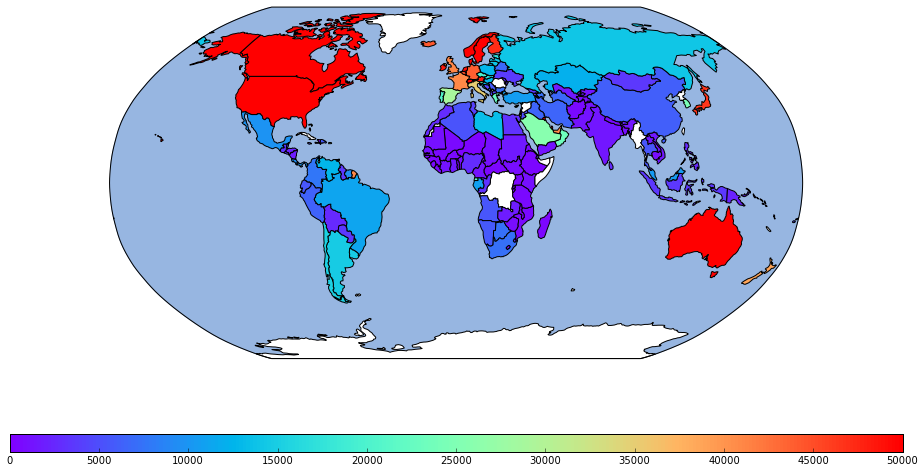

In [39]:
plot_map(countries, 'gdp per capita', max_value=50000)

In [40]:
CONFLICT_INTENSIFICATION_FACTOR = .01
GENEROSITY_FACTOR = 1e-9
POVERTY_LIMIT = 12000

In [41]:
while add_up(countries, 'net climate refugees') > 0:
    for country in countries:
        temperature = country.properties['temperature']
        net_refugees = country.properties['net refugees']
        gdp_per_capita = country.properties['gdp per capita']
        population = country.properties['population']
        more_of_the_same_refugees = min(0, net_refugees) * CONFLICT_INTENSIFICATION_FACTOR
        share_the_wealth_refugees = (-1) * max(0, gdp_per_capita - POVERTY_LIMIT) * population * GENEROSITY_FACTOR
        refugees_incoming = more_of_the_same_refugees + share_the_wealth_refugees
        if math.isfinite(refugees_incoming):
            country.properties['net climate refugees'] += refugees_incoming

Total net climate refugees: 29.60 millions.
Total net climate refugees: 29.43 millions.
Total net climate refugees: 29.27 millions.
Total net climate refugees: 29.10 millions.
Total net climate refugees: 28.94 millions.
Total net climate refugees: 28.77 millions.
Total net climate refugees: 28.61 millions.
Total net climate refugees: 28.44 millions.
Total net climate refugees: 28.28 millions.
Total net climate refugees: 28.12 millions.
Total net climate refugees: 27.95 millions.
Total net climate refugees: 27.79 millions.
Total net climate refugees: 27.62 millions.
Total net climate refugees: 27.46 millions.
Total net climate refugees: 27.29 millions.
Total net climate refugees: 27.13 millions.
Total net climate refugees: 26.96 millions.
Total net climate refugees: 26.80 millions.
Total net climate refugees: 26.64 millions.
Total net climate refugees: 26.47 millions.
Total net climate refugees: 26.31 millions.
Total net climate refugees: 26.14 millions.
Total net climate refugees: 25.9

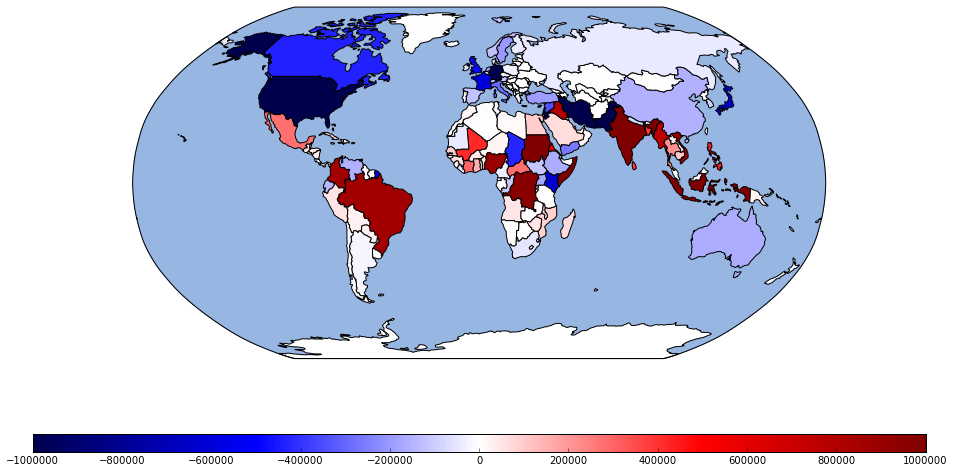

In [38]:
plot_map(countries, 'net climate refugees', max_value=1e6, min_value = -1e6, colormap='seismic')